In [12]:
# Import packages for later use
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from mlxtend.regressor import StackingCVRegressor
from catboost import Pool, cv, CatBoostRegressor
from scipy.special import boxcox1p
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [13]:
# Get the data
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

train_data['Training'] = 1
test_data['Training'] = 0
numerical_features = train_data.dtypes[train_data.dtypes != 'object'].index.values
categorical_features = train_data.dtypes[train_data.dtypes == 'object'].index.values
submit = ['SalePrice', 'Id']
significant_columns_cat = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish',
 'FireplaceQu', 'Foundation', 'GarageType', 'BsmtFinType1', 'HeatingQC',
 'MasVnrType', 'BsmtExposure', 'SaleCondition', 'Exterior1st', 'Exterior2nd',
 'SaleType', 'MSZoning', 'HouseStyle', 'GarageQual', 'GarageCond']
y = train_data['SalePrice']

In [14]:
# preprocessing
# remove outliers
# LotFrontage > 300
train_data.drop(train_data[train_data['LotFrontage']>300].index)
# LotArea > 100000
train_data.drop(train_data[train_data['LotArea']>100000].index)
# BsmtFinSF1 > 4000
train_data.drop(train_data[train_data['BsmtFinSF1']>4000].index)
# GrLivArea > 4000
train_data.drop(train_data[train_data['GrLivArea']>4000].index)
# TotalBsmtSF > 5000
train_data.drop(train_data[train_data['TotalBsmtSF']>5000].index)
# OpenPorchSF > 500
train_data.drop(train_data[train_data['OpenPorchSF']>500].index)
# 1stFlrSF > 4000
train_data.drop(train_data[train_data['1stFlrSF']>4000].index)

# concat
all_data = pd.concat([train_data, test_data], ignore_index=True)

# fill categoricals
categoricals = all_data[categorical_features]
categoricals['MSZoning'] = categoricals['MSZoning'].fillna(categoricals['MSZoning'].mode()[0])
categoricals.fillna('None', inplace=True)
all_data[categorical_features] = categoricals

# fill in numeric
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
all_data.fillna(0, inplace=True)

In [15]:
# select significant columns
significant_columns = [*significant_columns_cat, *numerical_features]
all_data = all_data[significant_columns]

# convert non-categorical to categorical
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# add in more features
all_data['TotalSF'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']
all_data['Bathrooms'] = all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath'] + all_data['HalfBath']) * 0.5
all_data['QualSF'] = all_data['TotalSF'] * all_data['OverallQual']
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasRemod'] = (all_data['YearBuilt'] - all_data['YearRemodAdd']).apply(lambda x: 1 if x != 0 else 0)
all_data['Has3SsnPorch'] = all_data['3SsnPorch'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasLowQualFin'] = all_data['LowQualFinSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['IsNew'] = (all_data['YrSold'] - all_data['YearBuilt']).apply(lambda x: 1 if x == 0 else 0)
all_data['TotalPorch'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
all_data['HasPorch'] = all_data['TotalPorch'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# binning
all_data['OpenPorchSF'] = pd.cut(all_data['OpenPorchSF'], [0, 5, 100, 300, 1000], include_lowest=True, labels=False)
all_data['OpenPorchSF'] = all_data['OpenPorchSF'].apply(str)
all_data['EnclosedPorch'] = pd.cut(all_data['EnclosedPorch'], [0, 5, 100, 250, 1000], include_lowest=True, labels=False)
all_data['EnclosedPorch'] = all_data['EnclosedPorch'].apply(str)
all_data['ScreenPorch'] = pd.cut(all_data['ScreenPorch'], [0, 5, 200, 1000], include_lowest=True, labels=False)
all_data['ScreenPorch'] = all_data['ScreenPorch'].apply(str)

# dropping a few columns
to_drop = ['MoSold', 'PoolArea', 'GarageYrBlt', '3SsnPorch', 'YearRemodAdd', 'LowQualFinSF']
all_data.drop(columns=to_drop, inplace=True)
# drop saleprice
all_data.drop(columns='SalePrice', inplace=True)

# redefine categoricals
numerical_features = all_data.dtypes[all_data.dtypes != 'object'].index.values
categorical_features = all_data.dtypes[all_data.dtypes == 'object'].index.values

In [16]:
# process skewness in features
skewness_cap = 2 # can change this number around a bit
# define ignored features
ignored_features = ['HasPool', 'HasGarage', 'HasRemod', 'Has3SsnPorch', 'HasLowQualFin', 'IsNew', 'HasPorch']
# find skewness
skewness = all_data[numerical_features].apply(lambda x: st.skew(x)).sort_values(ascending=False)
skewness_features = skewness[abs(skewness) > skewness_cap].index
skewness_features = [f for f in skewness_features if f not in ignored_features]
# box-cox transform
for col in skewness_features:
    all_data[col] = boxcox1p(all_data[col], st.boxcox_normmax(all_data[col] + 1))

adjusted_skewness = all_data[skewness_features].apply(lambda x: st.skew(x))

skewness_compare = pd.DataFrame()
skewness_compare['Features'] = skewness_features
skewness_compare['Original'] = skewness[skewness_features].values
skewness_compare['Adjusted'] = adjusted_skewness.values
skewness_compare


,Features,Original,Adjusted
0,MiscVal,21.947195,5.239894
1,LotArea,12.822431,-0.135401
2,KitchenAbvGr,4.302254,3.779896
3,BsmtFinSF2,4.146143,2.579468
4,BsmtHalfBath,3.931594,3.780960
5,MasVnrArea,2.613592,0.976354
6,TotalPorch,2.237266,0.355462
7,QualSF,2.143979,0.066933


In [17]:
# process categoricals
all_data = pd.get_dummies(data=all_data)

In [18]:
# Split up the dataset
train_set = all_data.loc[all_data['Training'] == 1]
test_set = all_data.loc[all_data['Training'] == 0]

# obtain X & y
# y = train_set['SalePrice']
y_log = np.log1p(y)
target_y = y_log

omit = ['SalePrice', 'Id', 'Training']
X = train_set[[c for c in train_set.columns if c not in omit]]
X_test = test_set[[c for c in test_set.columns if c not in omit]]

# further split into validation set and training set
x_train, x_validation, y_train, y_validation = train_test_split(X, target_y, test_size=0.1, random_state=27)
eval_set = [(x_validation, y_validation)]


In [19]:
# Spectate the final form of features
X.head()


,LotFrontage,LotArea,OverallQual,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,OpenPorchSF_2,OpenPorchSF_3,EnclosedPorch_0.0,EnclosedPorch_1.0,EnclosedPorch_2.0,EnclosedPorch_3.0,EnclosedPorch_nan,ScreenPorch_0,ScreenPorch_1,ScreenPorch_2
0,65.0,13.424521,7,2003,19.378556,706.0,0.0,150.0,856.0,856,...,0,0,1,0,0,0,0,1,0,0
1,80.0,13.694528,6,1976,0.000000,978.0,0.0,284.0,1262.0,1262,...,0,0,1,0,0,0,0,1,0,0
2,68.0,14.034134,7,2001,17.721067,486.0,0.0,434.0,920.0,920,...,0,0,1,0,0,0,0,1,0,0
3,60.0,13.683422,7,1915,0.000000,216.0,0.0,540.0,756.0,961,...,0,0,0,0,0,1,0,1,0,0
4,84.0,14.550143,8,2000,25.323124,655.0,0.0,490.0,1145.0,1145,...,0,0,1,0,0,0,0,1,0,0


In [20]:
np.shape(X)

(1460, 232)

In [21]:
# create lasso model for log transformed data
alphas = np.arange(1e-5, 1e-2, 1e-5)
lasso_reg = LassoCV(cv=5, 
    random_state=0, 
    max_iter=50000, 
    alphas=alphas).fit(X, target_y)

0.00042000000000000007
232
51


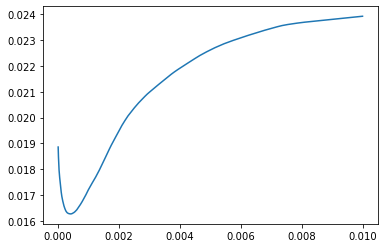

In [23]:
# Analysis for Lasso
best_alpha = lasso_reg.alpha_
coefficient = lasso_reg.coef_
non_zero_coef = [c for c in coefficient if c > 0]

print(best_alpha)
print(len(coefficient))
print(len(non_zero_coef))
mse_path_lasso = np.mean(lasso_reg.mse_path_, axis=1)
plt.plot(lasso_reg.alphas_, mse_path_lasso)

In [24]:
# create ridge model for log transformed data
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 75, 100]
ridge_reg = RidgeCV(cv=5, 
    alphas=ridge_alphas).fit(X, target_y)

In [25]:
# Analysis for Ridge
best_ridge_alpha = ridge_reg.alpha_
print('Ridge alpha:', best_ridge_alpha)
print('Score:', ridge_reg.best_score_)

Ridge alpha: 10.0
Score: 0.8948741629204632


In [26]:
# SVR(C=20, epsilon=0.01, gamma=0.0003)
svr_model = SVR()
clf = GridSearchCV(svr_model,
    {'C': [1, 5, 10, 20],
    'epsilon': [0.1, 0.01, 0.001],
    'gamma': (0.001, 0.0001, 'auto')
    }, verbose=1, n_jobs=1)
clf.fit(X, target_y)

print(clf.best_score_)
print(clf.best_params_)
best_svr_c = clf.best_params_['C']
best_svr_epsilon = clf.best_params_['epsilon']
best_svr_gamma = clf.best_params_['gamma']

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.6min finished
0.16279471986880936
{'C': 5, 'epsilon': 0.001, 'gamma': 0.0001}


In [28]:
# grid search for xgb
xgb_model = XGBRegressor(n_jobs=1, gamma=0, n_estimators=5000)
clf = GridSearchCV(xgb_model,
    {'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6]
    }, verbose=1, n_jobs=1)
clf.fit(X, target_y)

print(clf.best_score_)
print(clf.best_params_)
best_rate_xgb = clf.best_params_['learning_rate']
best_depth_xgb = clf.best_params_['max_depth']

xgb_model = XGBRegressor(n_jobs=1, gamma=0, n_estimators=5000, learning_rate=best_rate_xgb, max_depth=best_depth_xgb)
clf = GridSearchCV(xgb_model,
    {'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
    }, verbose=1, n_jobs=1)
clf.fit(X, target_y)

print(clf.best_score_)
print(clf.best_params_)
best_subsample_xgb = clf.best_params_['subsample']
best_colsample_bytree_xgb = clf.best_params_['colsample_bytree']

xgb_model = XGBRegressor(n_jobs=1, 
    gamma=0, 
    n_estimators=5000, 
    learning_rate=best_rate_xgb, 
    max_depth=best_depth_xgb,
    subsample=best_subsample_xgb,
    colsample_bytree=best_colsample_bytree_xgb)
clf = GridSearchCV(xgb_model,
    {'reg_alpha': [0.5, 0.7, 0.9],
    'reg_lambda': [0.5, 0.6, 0.8]
    }, verbose=1, n_jobs=1)
clf.fit(X, target_y)

print(clf.best_score_)
print(clf.best_params_)
best_alpha_xgb = clf.best_params_['reg_alpha']
best_lambda_xgb = clf.best_params_['reg_lambda']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 73.9min finished
0.8999422166032003
{'learning_rate': 0.01, 'max_depth': 3}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 101.9min finished
0.909623655676698
{'colsample_bytree': 0.5, 'subsample': 0.5}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 35.1min finished
0.9050834478870255
{'reg_alpha': 0.5, 'reg_lambda': 0.6}


In [66]:
# models and stacked
lasso = make_pipeline(RobustScaler(), Lasso(random_state=0, 
        max_iter=50000, 
        alpha=best_alpha)) 

xgb = XGBRegressor(n_jobs=1, 
    gamma=0, 
    n_estimators=5000, 
    learning_rate=0.01, 
    max_depth=3,
    subsample=0.7,
    reg_alpha=0.1,
    reg_lambda=0.6,
    scale_pos_weight=1,
    min_child_weight=0,
    random_state=27,
    objective='reg:squarederror',
    colsample_bytree=0.7)

ridge = make_pipeline(RobustScaler(), Ridge(alpha=best_ridge_alpha))

svr = make_pipeline(RobustScaler(), SVR(C=5, epsilon=0.001, gamma=0.0001))
# cat = CatBoostRegressor(iterations=5000,
#     depth=4,
#     random_seed=27, 
#     learning_rate=0.01)

stacked = StackingCVRegressor(regressors=(lasso, xgb, ridge, svr),
    meta_regressor=xgb,
    use_features_in_secondary=True)

In [67]:
lasso_train = lasso.fit(x_train, y_train)
ridge_train = ridge.fit(x_train, y_train)
svr_train = svr.fit(x_train, y_train)
xgb_train = xgb.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100, eval_metric='rmse')
# cat_train = cat.fit(x_train, y_train, eval_set=eval_set, early_stopping_rounds=100)

stacked_train = stacked.fit(np.array(x_train), np.array(y_train))

149
[905]	validation_0-rmse:0.14147
[906]	validation_0-rmse:0.14148
[907]	validation_0-rmse:0.14149
[908]	validation_0-rmse:0.14149
[909]	validation_0-rmse:0.14149
[910]	validation_0-rmse:0.14149
[911]	validation_0-rmse:0.14151
[912]	validation_0-rmse:0.14149
[913]	validation_0-rmse:0.14148
[914]	validation_0-rmse:0.14148
[915]	validation_0-rmse:0.14149
[916]	validation_0-rmse:0.14148
[917]	validation_0-rmse:0.14151
[918]	validation_0-rmse:0.14151
[919]	validation_0-rmse:0.14150
[920]	validation_0-rmse:0.14149
[921]	validation_0-rmse:0.14145
[922]	validation_0-rmse:0.14143
[923]	validation_0-rmse:0.14142
[924]	validation_0-rmse:0.14141
[925]	validation_0-rmse:0.14140
[926]	validation_0-rmse:0.14132
[927]	validation_0-rmse:0.14133
[928]	validation_0-rmse:0.14130
[929]	validation_0-rmse:0.14128
[930]	validation_0-rmse:0.14128
[931]	validation_0-rmse:0.14128
[932]	validation_0-rmse:0.14118
[933]	validation_0-rmse:0.14112
[934]	validation_0-rmse:0.14114
[935]	validation_0-rmse:0.14116
[936

In [68]:
# Combining
def rmse(y1, y2):
    return np.sqrt(metrics.mean_squared_error(y1, y2))

pred_lasso = lasso_train.predict(x_validation)
pred_xgb = xgb_train.predict(x_validation)
pred_ridge = ridge_train.predict(x_validation)
pred_svr = svr_train.predict(x_validation)
pred_stacked = stacked_train.predict(np.array(x_validation))

min_error = 100
best_lasso_weight = 0
best_xgb_weight = 0
best_ridge_weight = 0
best_svr_weight = 0
best_stacked_weight = 0
count = 0

good_weights = pd.DataFrame(columns=['Lasso', 'XGB', 'Ridge', 'SVR', 'Stacked', 'Error'])

print('Start looking for good weight...')
for lasso_weight in np.arange(0, 1, 0.05):
    xgb_weights = np.arange(0, 1 - lasso_weight, 0.05)
    for xgb_weight in xgb_weights:
        ridge_weights = np.arange(0, 1 - lasso_weight - xgb_weight, 0.05)
        for ridge_weight in ridge_weights:
            svr_weights = np.arange(0, 1 - lasso_weight - xgb_weight - ridge_weight, 0.05)
            for svr_weight in svr_weights:
                stacked_weight = 1 - lasso_weight - xgb_weight - ridge_weight - svr_weight
                
                count = count + 1
                y_pred_val = (stacked_weight * pred_stacked + 
                    xgb_weight * pred_xgb + 
                    lasso_weight * pred_lasso + 
                    svr_weight * pred_svr + 
                    ridge_weight * pred_ridge)
                
                error = rmse(y_validation, y_pred_val)
                if error < 0.13:
                    good_weights = good_weights.append({
                        'Lasso': lasso_weight,
                        'XGB': xgb_weight,
                        'Ridge': ridge_weight,
                        'SVR': svr_weight,
                        'Stacked': stacked_weight,
                        'Error': error
                        }, ignore_index=True)
                if error < min_error:
                    print('Found better weighting at iteration:', count)
                    print(min_error, '->', error)
                    min_error = error
                    best_lasso_weight = lasso_weight
                    best_xgb_weight = xgb_weight
                    best_svr_weight = svr_weight
                    best_ridge_weight = ridge_weight
                    best_stacked_weight = stacked_weight

print('Best Lasso Weight', best_lasso_weight)
print('Best XGB Weight', best_xgb_weight)
print('Best Stacked Weight', best_stacked_weight)
print('Best Ridge Weight', best_ridge_weight)
print('Best SVR Weight', best_svr_weight)

good_weights = good_weights.sort_values('Error')

Start looking for good weight...
Found better weighting at iteration: 1
100 -> 0.13357423143015235
Found better weighting at iteration: 2
0.13357423143015235 -> 0.13334411128761625
Found better weighting at iteration: 3
0.13334411128761625 -> 0.13319900157232156
Found better weighting at iteration: 4
0.13319900157232156 -> 0.1331390866252337
Found better weighting at iteration: 22
0.1331390866252337 -> 0.13297189271675897
Found better weighting at iteration: 23
0.13297189271675897 -> 0.13285651298371254
Found better weighting at iteration: 24
0.13285651298371254 -> 0.13282659928466212
Found better weighting at iteration: 41
0.13282659928466212 -> 0.13266328173515785
Found better weighting at iteration: 42
0.13266328173515785 -> 0.1325778529428774
Found better weighting at iteration: 58
0.1325778529428774 -> 0.13255978358104298
Found better weighting at iteration: 59
0.13255978358104298 -> 0.13241874991147876
Found better weighting at iteration: 60
0.13241874991147876 -> 0.1323634827806

In [69]:
good_weights.head(20)

,Lasso,XGB,Ridge,SVR,Stacked,Error
53,0.55,0.10,0.0,0.00,0.35,0.129572
70,0.60,0.10,0.0,0.00,0.30,0.129577
67,0.60,0.05,0.0,0.00,0.35,0.129577
48,0.55,0.05,0.0,0.00,0.40,0.129580
56,0.55,0.15,0.0,0.00,0.30,0.129611
73,0.60,0.15,0.0,0.00,0.25,0.129625
33,0.50,0.10,0.0,0.00,0.40,0.129625
63,0.60,0.00,0.0,0.00,0.40,0.129625
80,0.65,0.05,0.0,0.00,0.30,0.129632
44,0.55,0.00,0.0,0.00,0.45,0.129638


In [70]:
final_lasso = Lasso(random_state=0, 
    max_iter=50000, 
    alpha=best_alpha).fit(X, target_y)

final_stacked = StackingCVRegressor(regressors=(lasso, xgb, ridge, svr),
    meta_regressor=xgb,
    use_features_in_secondary=True,
    random_state=27).fit(np.array(X), np.array(target_y))

final_ridge = ridge.fit(X, target_y)
final_svr = svr.fit(X, target_y)
final_xgb = xgb_train

In [118]:
# prediction result
pred_xgb = final_xgb.predict(X_test)
pred_lasso = final_lasso.predict(X_test)
pred_ridge = final_ridge.predict(X_test)
pred_svr = final_svr.predict(X_test)
pred_stacked = final_stacked.predict(np.array(X_test))

y_pred = 0.4 * pred_stacked + 0.4 * pred_lasso + 0.0 * pred_svr + 0.2 * pred_xgb
y_final_test = np.expm1(y_pred)

In [119]:
# submission
test_data['SalePrice'] = y_final_test
submit = ['SalePrice', 'Id']
submission = test_data[[c for c in test_data.columns if c in submit]]
submission.to_csv('./data/teamJarvis_stacked.csv', index=False)